In [35]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [94]:
atlas_2019 = pd.read_csv('../data/processed/processed_atlas_2019.csv')
atlas_2015 = pd.read_csv('../data/processed/processed_atlas_2015.csv')
atlas_2010 = pd.read_csv('../data/processed/processed_atlas_2010.csv')

In [95]:
ordered_columns = [
    "CensusTract",
    "Urban",
    "PovertyRate",
    "MedianFamilyIncome",
    "TractLOWI",
    "TractKids",
    "TractSeniors",
    "TractHUNV",
    "TractSNAP",
    "lapop1share",
    "lalowi1share",
    "lakids1share",
    "laseniors1share",
    "lahunv1share",
    "POP2010",
    "LOWIRatio",
    "SNAPRatio",
    "HUNVRatio",
    "FoodInsecurityIndex",
    "LOWIWeighted"
]


We provide an ordered list of columns for the three datasets to follow given that to calculate Deltas (differences) we will need to align the columns to one another.

In [97]:
atlas_dataset_2010 = atlas_2010.copy()
atlas_dataset_2015 = atlas_2015.copy()
atlas_dataset_2019 = atlas_2019.copy()


atlas_dataset_2010.drop(columns=['Unnamed: 0'])
atlas_dataset_2015.drop(columns=['Unnamed: 0'])
atlas_dataset_2019.drop(columns=['Unnamed: 0'])

atlas_dataset_2010 = atlas_dataset_2010[ordered_columns]
atlas_dataset_2015 = atlas_dataset_2015[ordered_columns]
atlas_dataset_2019 = atlas_dataset_2019[ordered_columns]

pd.set_option('display.max_columns', None)

In [98]:
cluster_labels_2019 = pd.read_csv('../data/processed/random_forest_labels_2019.csv')
cluster_labels_2015 = pd.read_csv('../data/processed/random_forest_labels_2015.csv')
cluster_labels_2010 = pd.read_csv('../data/processed/random_forest_labels_2010.csv')
print(cluster_labels_2019.head())
print(cluster_labels_2015.head())
print(cluster_labels_2010.head())

   CensusTract  2019_cluster
0   1001020100             2
1   1001020200             1
2   1001020300             1
3   1001020400             2
4   1001020500             2
   CensusTract  2015_cluster
0   1001020100             2
1   1001020200             2
2   1001020300             0
3   1001020400             2
4   1001020500             2
   CensusTract  2010_cluster
0   1001020100             2
1   1001020200             2
2   1001020300             1
3   1001020400             1
4   1001020500             2


In [99]:
print(cluster_labels_2019['2019_cluster'].value_counts().sort_index())
print(cluster_labels_2015['2015_cluster'].value_counts().sort_index())
print(cluster_labels_2010['2010_cluster'].value_counts().sort_index())

2019_cluster
0    22420
1    27209
2    22902
Name: count, dtype: int64
2015_cluster
0    18978
1    27185
2    26368
Name: count, dtype: int64
2010_cluster
0    21116
1    21895
2    29520
Name: count, dtype: int64


### Here is where the main compromise in our project is evident. 

While we have each annual dataset indendently cluster itself via K-Means in our previous notebook, this will of course come with differences between themselves.

While the differences between our sets could be attributed to cluster margin qualifications being somewhat different, I personally disagree with this opinon.

Our dataset-independent clusters EACH do an amazing job at differentiating food deserts themselves. As a result, I think it's safe to come to the conclusion that they are RELATIVELY similar, and the vasts shifts we see in "general" or "simplified" groups are simply socioeconomic trends. 

In [100]:
print(len(cluster_labels_2019))
print(len(cluster_labels_2015))
print(len(cluster_labels_2010))

72531
72531
72531


In [111]:
combined_pred_cols = pd.merge(cluster_labels_2015, cluster_labels_2010, on='CensusTract', how='inner')
combined_pred_cols.rename(columns={'2015_cluster': 'Current_Cluster'}, inplace=True)
combined_pred_cols.rename(columns={'2010_cluster': 'Previous_Cluster'}, inplace=True)
combined_pred_cols.head()

,CensusTract,Current_Cluster,Previous_Cluster
0,1001020100,2,2
1,1001020200,2,2
2,1001020300,0,1
3,1001020400,2,1
4,1001020500,2,2


In [116]:
combined_pred_cols_2019 = pd.merge(cluster_labels_2019, cluster_labels_2015, on='CensusTract', how='inner')
combined_pred_cols_2019.rename(columns={'2019_cluster': 'Current_Cluster'}, inplace=True)
combined_pred_cols_2019.rename(columns={'2015_cluster': 'Previous_Cluster'}, inplace=True)
combined_pred_cols_2019.head()

,CensusTract,Current_Cluster,Previous_Cluster
0,1001020100,2,2
1,1001020200,1,2
2,1001020300,1,0
3,1001020400,2,2
4,1001020500,2,2


To be able to use our XGBoost model that predicted data for 2019, we must keep column names vague and not specific for similar usage in 2025 tract data. 

In [117]:
print(len(cluster_labels_2019))
print(len(atlas_dataset_2010))
print(len(atlas_dataset_2015))
#2019 dataset was already aligned, which is what our cluster labels were created off of. 
#Another alignment is not necessary.

72531
72531
72531


In [118]:
training_atlas_2010 = atlas_dataset_2010.select_dtypes(include='number')
training_atlas_2015 = atlas_dataset_2015.select_dtypes(include='number')
training_dataset = training_atlas_2015 - training_atlas_2010
training_dataset['CensusTract'] = atlas_dataset_2015['CensusTract']
training_dataset['Urban'] = atlas_dataset_2015['Urban']
training_dataset = training_dataset.drop(columns=['POP2010'], errors='ignore')
training_dataset = pd.merge(training_dataset, combined_pred_cols, on='CensusTract', how='inner')
training_dataset = training_dataset.reset_index(drop=True)
training_dataset = training_dataset.drop(columns=['CensusTract'])
training_dataset.head()

,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lalowi1share,lakids1share,laseniors1share,lahunv1share,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted,Current_Cluster,Previous_Cluster
0,1.0,-0.0050,-3.082844e-06,0.009672,0.005234,0.006369,-0.003886,0.033103,-1.086098e-11,0.040171,-0.527048,-0.650294,-0.031467,0.066946,0.037657,-0.012552,0.092050,0.001244,2,2
1,1.0,0.0344,4.024491e-06,0.006121,0.000760,0.007238,-0.004534,0.062989,-4.688830e-10,-0.011842,-0.207861,-0.214718,-0.017174,0.037327,0.063134,-0.012903,0.087558,0.004244,2,2
2,1.0,0.1106,-6.552543e-07,0.041031,-0.008780,0.016907,0.001133,0.004138,-2.664360e-10,0.093641,-0.310036,-0.376475,-0.004658,0.160984,0.002668,0.002075,0.165728,0.024238,0,1
3,1.0,-0.0302,1.180057e-06,0.021158,-0.015196,0.040009,0.000000,-0.015632,-1.244433e-01,0.022441,-0.384580,-0.359846,0.002820,0.063839,-0.007752,0.000000,0.056088,-0.002198,2,1
4,1.0,0.0254,-3.534175e-06,0.095587,0.012664,0.053790,-0.004048,0.160000,-1.026874e-02,0.023189,-0.169473,-0.298401,-0.003129,0.117500,0.032324,-0.002322,0.147501,0.015972,2,2


In [119]:
training_atlas_2019 = atlas_dataset_2019.select_dtypes(include='number')
training_dataset_2019 = training_atlas_2019 - training_atlas_2015
training_dataset_2019['CensusTract'] = atlas_dataset_2019['CensusTract']
training_dataset_2019['Urban'] = atlas_dataset_2019['Urban']
training_dataset_2019 = training_dataset_2019.drop(columns=['POP2010'], errors='ignore')
training_dataset_2019 = pd.merge(training_dataset_2019, combined_pred_cols_2019, on='CensusTract', how='inner')
training_dataset_2019 = training_dataset_2019.reset_index(drop=True)
training_dataset_2019 = training_dataset_2019.drop(columns=['CensusTract'])
training_dataset_2019.head()

,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lalowi1share,lakids1share,laseniors1share,lahunv1share,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted,Current_Cluster,Previous_Cluster
0,1.0,0.013,0.000010,0.000529,0.0,0.0,-0.003238,-0.004598,0.281920,0.072646,0.073113,0.029412,-0.006202,0.003661,-0.005230,-0.010460,-0.012029,0.000735,2,2
1,1.0,-0.003,-0.000004,0.002947,0.0,0.0,0.000324,-0.021149,0.358321,0.211415,0.106361,0.034808,0.060877,0.017972,-0.021198,0.000922,-0.002304,0.000521,1,2
2,1.0,-0.041,0.000015,-0.020553,0.0,0.0,-0.001457,0.023908,0.039640,-0.064733,0.011592,0.003270,-0.010594,-0.080640,0.015417,-0.002668,-0.067892,-0.011720,1,0
3,1.0,-0.005,0.000004,-0.024105,0.0,0.0,0.000324,0.007356,0.000032,-0.015085,0.000020,-0.000028,-0.000500,-0.072731,0.003648,0.000456,-0.068627,-0.001682,2,2
4,1.0,0.067,0.000028,-0.034003,0.0,0.0,0.005181,-0.068506,-0.000004,-0.003374,0.000029,0.000006,0.002560,-0.041798,-0.013840,0.002972,-0.052666,0.012438,2,2


Here, we calculate the deltas each sets possess.

In [120]:
cluster_labels_2019 = cluster_labels_2019.reset_index(drop=True)

assert len(training_dataset) == len(cluster_labels_2019), "Features and labels must have same length!"

X_train, X_test, y_train, y_test = train_test_split(training_dataset, cluster_labels_2019['2019_cluster'], test_size=0.3, random_state=42)

Unlike our autoencoder/K-means model, we need a train/test set for our XGBoost prediction. 
    
For a brief refresher, the training and testing lables both stem from our clustered labels trained by the previous model. 

In [121]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [122]:
print("Number of samples:", len(y_train))
print("Number of unique classes:", len(np.unique(y_train)))

Number of samples: 50771
Number of unique classes: 3


In [123]:
xgb_model_weighted = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax'
)

xgb_model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

/home/radiant/yolov8-env/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:12:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [124]:
y_pred_xgb_weighted = xgb_model_weighted.predict(X_test)
print("XGBoost (with Sample Weights) accuracy:", accuracy_score(y_test, y_pred_xgb_weighted))
print(classification_report(y_test, y_pred_xgb_weighted))

XGBoost (with Sample Weights) accuracy: 0.772610294117647
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6670
           1       0.75      0.71      0.73      8284
           2       0.77      0.79      0.78      6806

    accuracy                           0.77     21760
   macro avg       0.77      0.78      0.78     21760
weighted avg       0.77      0.77      0.77     21760



The XGBoost model achieved a solid overall accuracy of 77.26%, with balanced performance across all three food insecurity risk clusters. The macro and weighted averages show consistent precision, recall, and F1-scores around 0.77–0.78, indicating the model generalizes well across both high- and low-risk tracts.

Wow, not bad but not exactly "good". 

Depending on what further diagnostics of this model state, we may actually have to trash it!?

In [125]:
model_confusion_matrix = confusion_matrix(y_test, y_pred_xgb_weighted)
model_pred_df = pd.DataFrame(
    model_confusion_matrix,
    index=['True 0', 'True 1', 'True 2'],
    columns=['Pred 0', 'Pred 1', 'Pred 2']
)

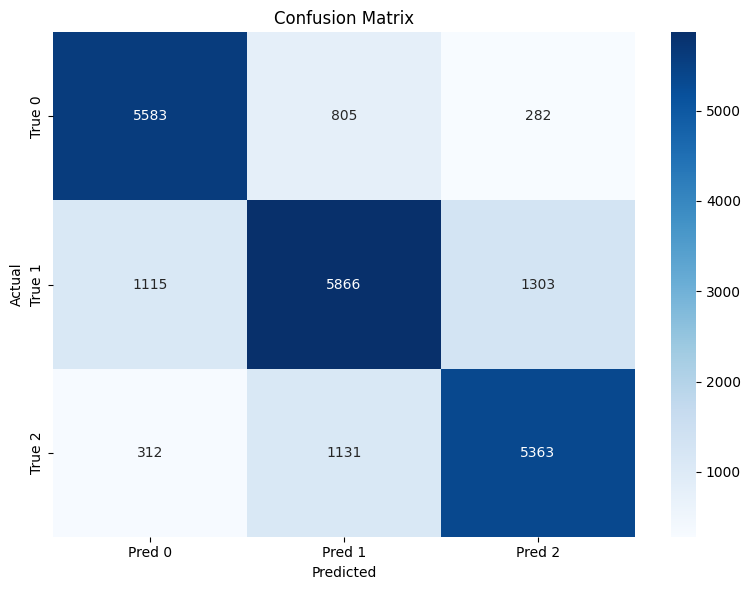

In [126]:
plt.figure(figsize=(8,6))
sns.heatmap(model_pred_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

#### What does this mean?
Although the XGBoost model is trained to predict future cluster designations based on historical trends, our ultimate goal is not just to classify tracts into static food insecurity risk levels (that would be semi-inaccurate). Instead, we interpret these predicted cluster changes as indicators of trajectory. Because the model was trained on temporal deltas, a tract predicted to shift from a low-risk to a high-risk cluster is treated as declining in food availability, while movement in the opposite direction signals improvement. This enables us to transform categorical predictions into directional forecasts, providing viewers with actionable insight into which areas are likely to worsen, remain stable, or improve in terms of food access!

#### Thank goodness!
It seems like a majority of our "wrong" classifications were not necessarily "insanely" volatile, but mostly off by one.
Given this new information, and recycled purpose...

We won't trash it!

In [127]:
explainer = shap.TreeExplainer(xgb_model_weighted)
shap_values = explainer.shap_values(X_test)

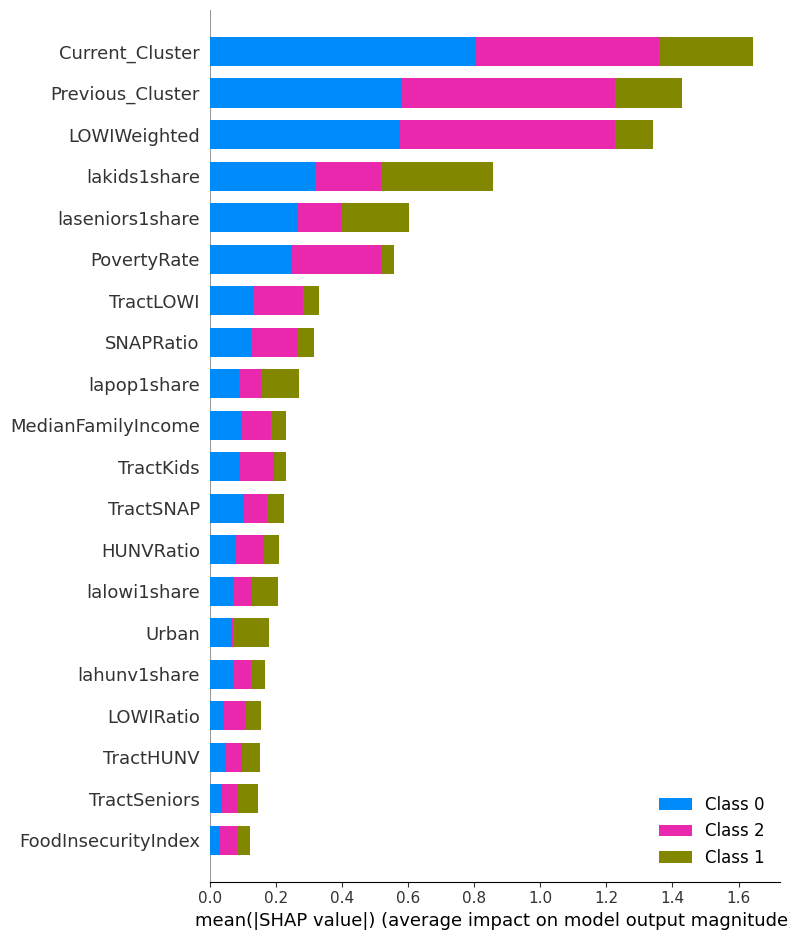

In [128]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

### Interesting!
The SHAP analysis reveals that the most influential features in the XGBoost model's predictions are current and previous cluster labels, followed by low-income weight (LOWIWeighted) and the proportion of young children and seniors in a tract. 

These results highlight the model’s STRONG reliance on temporal (insanely strong temporal correlations) and demographic context when forecasting future food insecurity status. Notably, broader socioeconomic indicators like poverty rate and SNAP usage ratios (which we feature engineered into existence within our processing data notebook) also contribute meaningfully, reinforcing the validity and interpretability of the model’s decision process.

In [141]:
y_pred_2019 = xgb_model_weighted.predict(training_dataset_2019)

In [147]:
print(len(y_pred_2019))
print(len(atlas_dataset_2019)) 

72506
72531


In [148]:
def align_dataframes_by_index(*dfs):
    common_index = dfs[0].index
    for df in dfs[1:]:
        common_index = common_index.intersection(df.index)
    aligned_dfs = tuple(df.loc[common_index].copy() for df in dfs)
    return aligned_dfs

In [155]:
aligned_atlas_2019 = atlas_dataset_2019.copy().reset_index(drop=True)
predictions_2025_data = pd.DataFrame(y_pred_2019, columns=['Predicted_Cluster'])
predictions_2025_data = predictions_2025_data.reset_index(drop=True)
predictions_2025_data, aligned_atlas_2019 = align_dataframes_by_index(predictions_2025_data, aligned_atlas_2019)

In [156]:
predictions_2025_data['CensusTract'] = aligned_atlas_2019['CensusTract'].values
predictions_2025_data.set_index('CensusTract', inplace=True)

In [157]:
predictions_2025_data.head()

,Predicted_Cluster
CensusTract,
1001020100,2
1001020200,2
1001020300,1
1001020400,2
1001020500,2


In [158]:
predictions_2025_data.to_csv('../data/processed/predicted_2025_food_desert_values.csv')

# Well, this is it!
NutriMap successfully combines unsupervised and supervised machine learning with geospatial data to identify, monitor, and forecast food insecurity risk across Houston census tracts. Using a clustering approach, we grouped tracts by shared patterns of vulnerability and visualized these risk levels interactively. We then trained an XGBoost model on historical tract data to predict future food insecurity designations, interpreting these predictions as directional changes: whether a tract is likely to improve, decline, or remain stable in terms of food access.

Model evaluation showed strong classification performance, and SHAP analysis confirmed that predictions are grounded in meaningful socioeconomic and demographic indicators, such as poverty rates, youth and senior population shares, and previous food insecurity status. These insights not only validate the model's reasoning but also provide actionable guidance for policy, resource allocation, and especially long-term planning.

NutriMap is more than a visualization, it's a predictive tool for proactive intervention in the fight against food deserts, and its pipeline can be adapted to any U.S. region with appropriate census data.

In [1]:
### Thank you so much for reading through the journals of my first Machine learning project!
### NutriMap was an amazing learning experience, and I truly felt the pains feature engineering employs on the soul😭
### My next projects will be even larger and more complex, so if you loved NutriMap, feel free to stalk my GitHub!